In [1]:

import json 
import os
import re
import random

import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split



import torchtext
from torchtext import data
from torchtext import datasets
from torchtext.datasets import text_classification

from torchtext.data import Field, Example, TabularDataset
from torchtext.data import BucketIterator
from torchtext.data.utils import ngrams_iterator
from torchtext.data.utils import get_tokenizer


# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Gensim
import gensim
from gensim.utils import simple_preprocess

# NLTK
import nltk
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

from sklearn.preprocessing import MultiLabelBinarizer

from yellowbrick.text import TSNEVisualizer

import warnings 


random.seed(128)

sourced: 
    https://github.com/MageshDominator/Blog_References/tree/master/ML%20based%20Multi-label%20Text%20Classification
        https://medium.com/technovators/machine-learning-based-multi-label-text-classification-9a0e17f88bb4

Load Data

In [2]:
def extract_json_object(filename):
    with open(file, "r", encoding='utf-8') as read_file:
        json_array = json.load(read_file)
    json_data = []    
    #parse the data
    for item in json_array:
        details = {"id":None, "labels":None, "text":None}
        details['id'] = item['id']
        try: 
            details['labels'] = item['labels']
        except KeyError: 
            details['labels'] = []         
        details['text'] = item['text']
        json_data.append(details)

    
    return json_data


In [3]:
# file paths
lst_file_path=[]

lst_file_path.append("../data/training_data_task3.txt")

lst_file_path.append("../data/validation_data_task3.txt")


# List of keys 
dataset = ["training", "validation"] 
# empty dictionary
dic_datasets =  dict.fromkeys(dataset, pd.DataFrame()) 

  



In [4]:
for i, file in enumerate(lst_file_path):
    print('loading'+ file)
    dic_datasets[dataset[i]] = pd.DataFrame(extract_json_object(extract_json_object))

loading../data/training_data_task3.txt
loading../data/validation_data_task3.txt


Seperate data into each components
<br>Training, Dev and Test
<br>Also apply no class to empty []

In [5]:
df_training = pd.DataFrame(dic_datasets['training'][['id','labels','text']])
df_training.labels = df_training.labels.apply(lambda y: ['no_class'] if len(y)==0 else y)

df_val = pd.DataFrame(dic_datasets['validation'][['id','labels','text']])
df_val.labels = df_val.labels.apply(lambda y: ['no_class'] if len(y)==0 else y)



Review Datasets

In [6]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 547 entries, 0 to 546
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      547 non-null    object
 1   labels  547 non-null    object
 2   text    547 non-null    object
dtypes: object(3)
memory usage: 12.9+ KB


In [7]:
df_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140 entries, 0 to 139
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      140 non-null    object
 1   labels  140 non-null    object
 2   text    140 non-null    object
dtypes: object(3)
memory usage: 3.4+ KB


In order to properly process, we need to combine all labels of the datasets

In [8]:
df_concat_labels = pd.concat([df_training.pop('labels'), df_val.pop('labels')])

Review labels

In [9]:
df_concat_labels

0      [Appeal to fear/prejudice, Causal Oversimplifi...
1                                      [Loaded Language]
2      [Appeal to (Strong) Emotions, Reductio ad hitl...
3                                               [Smears]
4      [Appeal to (Strong) Emotions, Name calling/Lab...
                             ...                        
135                                             [Smears]
136    [Loaded Language, Name calling/Labeling, Reduc...
137    [Appeal to (Strong) Emotions, Appeal to fear/p...
138                                    [Loaded Language]
139    [Glittering generalities (Virtue), Loaded Lang...
Name: labels, Length: 687, dtype: object

len(df_training)use multilabel Binarizer <br>
Use combined set and then resplit

In [10]:
len(df_training)

547

In [11]:
len(df_training) + len(df_val)

687

In [12]:
mlb = MultiLabelBinarizer(sparse_output=True)


concat_labels = df_training.join(pd.DataFrame.sparse.from_spmatrix(
                    mlb.fit_transform(df_concat_labels),
                    index=df_concat_labels.index,
                    columns=mlb.classes_))


train_labels = concat_labels[0:len(df_training)]


val_labels = concat_labels[len(df_training):]




ensure split off occured correctly

In [13]:
len(df_training)

547

In [14]:
len(df_val)

140

In [15]:
len(train_labels)

547

In [16]:
len(val_labels)

140

remove the text field from the labels dataset

In [17]:
train_labels = train_labels.drop(['text'], axis=1)
val_labels = val_labels.drop(['text'], axis=1)


print(train_labels.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 0 to 406
Data columns (total 24 columns):
 #   Column                                               Non-Null Count  Dtype           
---  ------                                               --------------  -----           
 0   id                                                   547 non-null    object          
 1   Appeal to (Strong) Emotions                          547 non-null    Sparse[int32, 0]
 2   Appeal to authority                                  547 non-null    Sparse[int32, 0]
 3   Appeal to fear/prejudice                             547 non-null    Sparse[int32, 0]
 4   Bandwagon                                            547 non-null    Sparse[int32, 0]
 5   Black-and-white Fallacy/Dictatorship                 547 non-null    Sparse[int32, 0]
 6   Causal Oversimplification                            547 non-null    Sparse[int32, 0]
 7   Doubt                                                547 non-null    Sp

Review labels

In [18]:
val_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 407 to 546
Data columns (total 24 columns):
 #   Column                                               Non-Null Count  Dtype           
---  ------                                               --------------  -----           
 0   id                                                   140 non-null    object          
 1   Appeal to (Strong) Emotions                          140 non-null    Sparse[int32, 0]
 2   Appeal to authority                                  140 non-null    Sparse[int32, 0]
 3   Appeal to fear/prejudice                             140 non-null    Sparse[int32, 0]
 4   Bandwagon                                            140 non-null    Sparse[int32, 0]
 5   Black-and-white Fallacy/Dictatorship                 140 non-null    Sparse[int32, 0]
 6   Causal Oversimplification                            140 non-null    Sparse[int32, 0]
 7   Doubt                                                140 non-null    

Combine all text and then vectorize to be able to model using TFIDVectorizer

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

df_concat = pd.concat([df_training["text"] , df_val["text"]])


vectorizer = TfidfVectorizer()
vectorised_train_documents = vectorizer.fit_transform(df_concat)


Vectorize the dev text 

In [20]:
vectorised_val_documents = vectorizer.transform(df_val["text"])
df_val["text"]

0           I can't breath but don't worry, I'm white.\n
1      SORRY, BUT I DON'T LISTEN TO ANTI-GUN LECTURES...
2      ON MY WAY BACK TO THE WHITE HOUSE\n\nMR. TRUMP...
3      For those times when you just can't make it to...
4      SAYING YOU ARE A PATRIOT IS NOT ENOUGH\n\nYOU ...
                             ...                        
135                                     SHE AIN'T BLACK.
136    Losers can keep watching sweaty NFL thugs supp...
137    PEOPLE KEEP ASKING: "WHY DID GOD TURN HIS BACK...
138    Trump didn't make America racist...\n\nHe made...
139    President Trump's rallies should feature a wal...
Name: text, Length: 140, dtype: object

Get feature names and present the top 50 words, notice no data transforms or data clensing has occured (will do on another pass)

In [21]:

from yellowbrick.text import FreqDistVisualizer
features = vectorizer.get_feature_names()


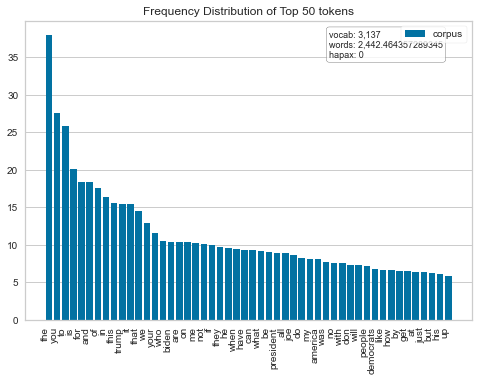

<AxesSubplot:title={'center':'Frequency Distribution of Top 50 tokens'}>

In [22]:
visualizer = FreqDistVisualizer(features=features, orient='v')
visualizer.fit(vectorised_train_documents)
visualizer.show()

Visualize the entire corpus (using  T-SNE) <br>
also shows how many documents are in the corpus

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


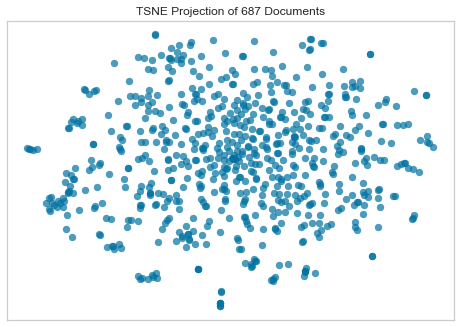

<AxesSubplot:title={'center':'TSNE Projection of 687 Documents'}>

In [23]:
tsne = TSNEVisualizer()
tsne.fit(vectorised_train_documents)
tsne.show()


Visualizaing corpus with Uniform Manifold Approximation and Projection

D:\Users\sync\anaconda3\envs\pytorch\lib\site-packages\umap\umap_.py:125: UserWarning: A few of your vertices were disconnected from the manifold.  This shouldn't cause problems.
Disconnection_distance = 1 has removed 224634 edges.
It has only fully disconnected 1 vertices.
Use umap.utils.disconnected_vertices() to identify them.
  warn(
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


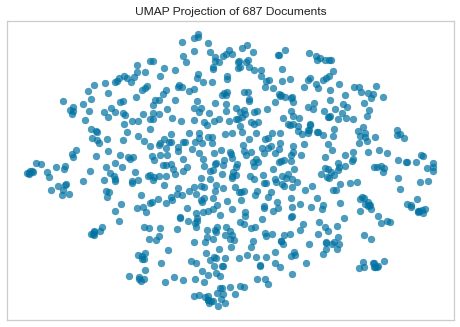

<AxesSubplot:title={'center':'UMAP Projection of 687 Documents'}>

In [24]:

from yellowbrick.text import UMAPVisualizer
from sklearn.cluster import KMeans

umap = UMAPVisualizer(metric="cosine")
umap.fit(vectorised_train_documents)
umap.show()

Model Performance

In [25]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss

ModelsPerformance = {}

def metricsReport(modelName, test_labels, predictions, labels):
    accuracy = accuracy_score(test_labels, predictions)

    macro_precision = precision_score(test_labels, predictions, average='macro', zero_division=1)
    macro_recall = recall_score(test_labels, predictions, average='macro', zero_division=1)
    macro_f1 = f1_score(test_labels, predictions, average='macro', zero_division=1)

    micro_precision = precision_score(test_labels, predictions, average='micro', zero_division=1)
    micro_recall = recall_score(test_labels, predictions, average='micro', zero_division=1)
    micro_f1 = f1_score(test_labels, predictions, average='micro', zero_division=1)
    hamLoss = hamming_loss(test_labels, predictions)
    print("------" + modelName + " Model Metrics-----")
    print("Accuracy: {:.4f}\nHamming Loss: {:.4f}\nPrecision:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nRecall:\n  - Macro: {:.4f}\n  - Micro: {:.4f}\nF1-measure:\n  - Macro: {:.4f}\n  - Micro: {:.4f}"\
          .format(accuracy, hamLoss, macro_precision, micro_precision, macro_recall, micro_recall, macro_f1, micro_f1))
    ModelsPerformance[modelName] = micro_f1
    print(metrics.classification_report(test_labels, predictions, zero_division=0, target_names = labels))

In [26]:
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 547 entries, 0 to 406
Data columns (total 24 columns):
 #   Column                                               Non-Null Count  Dtype           
---  ------                                               --------------  -----           
 0   id                                                   547 non-null    object          
 1   Appeal to (Strong) Emotions                          547 non-null    Sparse[int32, 0]
 2   Appeal to authority                                  547 non-null    Sparse[int32, 0]
 3   Appeal to fear/prejudice                             547 non-null    Sparse[int32, 0]
 4   Bandwagon                                            547 non-null    Sparse[int32, 0]
 5   Black-and-white Fallacy/Dictatorship                 547 non-null    Sparse[int32, 0]
 6   Causal Oversimplification                            547 non-null    Sparse[int32, 0]
 7   Doubt                                                547 non-null    Sp

In [27]:
val_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 407 to 546
Data columns (total 24 columns):
 #   Column                                               Non-Null Count  Dtype           
---  ------                                               --------------  -----           
 0   id                                                   140 non-null    object          
 1   Appeal to (Strong) Emotions                          140 non-null    Sparse[int32, 0]
 2   Appeal to authority                                  140 non-null    Sparse[int32, 0]
 3   Appeal to fear/prejudice                             140 non-null    Sparse[int32, 0]
 4   Bandwagon                                            140 non-null    Sparse[int32, 0]
 5   Black-and-white Fallacy/Dictatorship                 140 non-null    Sparse[int32, 0]
 6   Causal Oversimplification                            140 non-null    Sparse[int32, 0]
 7   Doubt                                                140 non-null    

In [28]:
vectorised_val_documents

<140x3137 sparse matrix of type '<class 'numpy.float64'>'
	with 2129 stored elements in Compressed Sparse Row format>

knn Model <br>
k-nearest neighbors algorithm (kNN) is a non-parametric technique used for classification. <br>

Given a test document x, the KNN algorithm finds the k nearest neighbors of x among all the documents in the training set, and scores the category <br> candidates based the class of k neighbors. The similarity of x and each neighbor’s document could be the score of the category of the neighbor documents. <br> Multiple KNN documents may belong to the same category; in this case, the summation of these scores would be the similarity score of class k with <br> respect to the test document x. After sorting the score values, the algorithm assigns the candidate to the class with the highest score from the test<br>document x

In [29]:

from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

knnClf = KNeighborsClassifier()

knnClf.fit(vectorised_train_documents[1:len(df_training["text"])+1], train_labels.drop(['id'], axis=1).sparse.to_dense())
knnPredictions = knnClf.predict(vectorised_val_documents)
metricsReport("knn", val_labels.drop(['id'],axis=1), knnPredictions,list(val_labels.drop(['id'], axis=1).columns))

------knn Model Metrics-----
Accuracy: 0.0571
Hamming Loss: 0.1121
Precision:
  - Macro: 0.7092
  - Micro: 0.4879
Recall:
  - Macro: 0.1878
  - Micro: 0.2837
F1-measure:
  - Macro: 0.1866
  - Micro: 0.3588
                                                     precision    recall  f1-score   support

                        Appeal to (Strong) Emotions       0.00      0.00      0.00        14
                                Appeal to authority       0.00      0.00      0.00         5
                           Appeal to fear/prejudice       0.00      0.00      0.00        15
                                          Bandwagon       0.00      0.00      0.00         0
               Black-and-white Fallacy/Dictatorship       0.00      0.00      0.00         4
                          Causal Oversimplification       0.00      0.00      0.00         7
                                              Doubt       0.00      0.00      0.00        17
                          Exaggeration/Minimisati

Analysis Notes:
WIP


Decision Tree

Tree-based methods are simple and useful for interpretation. A decision tree is a flowchart-like structure in which each internal node represents a "test" on an attribute (e.g. whether a coin flip comes up heads or tails), each branch represents the outcome of the test, and each leaf node represents a class label (decision taken after computing all attributes). The paths from root to leaf represent classification rules.

In [30]:
from sklearn.tree import DecisionTreeClassifier

dtClassifier = DecisionTreeClassifier()
dtClassifier.fit(vectorised_train_documents[1:len(df_training["text"])+1], train_labels.drop(['id'], axis=1).sparse.to_dense())
dtPreds = dtClassifier.predict(vectorised_val_documents)
#metricsReport("Decision Tree", dev_labels.drop(['id'],axis=1).sparse.to_dense(), dtPreds)
metricsReport("Decision Tree", val_labels.drop(['id'],axis=1), dtPreds, list(val_labels.drop(['id'], axis=1).columns))

------Decision Tree Model Metrics-----
Accuracy: 0.0571
Hamming Loss: 0.1332
Precision:
  - Macro: 0.2984
  - Micro: 0.3904
Recall:
  - Macro: 0.2468
  - Micro: 0.3652
F1-measure:
  - Macro: 0.2035
  - Micro: 0.3774
                                                     precision    recall  f1-score   support

                        Appeal to (Strong) Emotions       0.15      0.14      0.15        14
                                Appeal to authority       0.00      0.00      0.00         5
                           Appeal to fear/prejudice       0.20      0.13      0.16        15
                                          Bandwagon       0.00      0.00      0.00         0
               Black-and-white Fallacy/Dictatorship       0.00      0.00      0.00         4
                          Causal Oversimplification       0.20      0.29      0.24         7
                                              Doubt       0.25      0.18      0.21        17
                          Exaggeration/

Analysis Notes:
WIP


Bagging Classifier <br>
The decision trees suffer from high variance. <br>
This means that if we split the training data into two parts at random, and fit a decision tree to both halves, the results that we get could be quite different. <br>
Bootstrap aggregation, or bagging, is a general-purpose procedure for reducing the variance of a statistical learning method; we introduce it here because it is particularly useful and frequently used in the context of decision trees.

In [31]:
from sklearn.ensemble import BaggingClassifier

bagClassifier = OneVsRestClassifier(BaggingClassifier(n_jobs=-1))
bagClassifier.fit(vectorised_train_documents[1:len(df_training["text"])+1], train_labels.drop(['id'], axis=1).sparse.to_dense())
bagPreds = bagClassifier.predict(vectorised_val_documents)
metricsReport("Bagging", val_labels.drop(['id'],axis=1), bagPreds, list(val_labels.drop(['id'], axis=1).columns))

------Bagging Model Metrics-----
Accuracy: 0.0714
Hamming Loss: 0.1090
Precision:
  - Macro: 0.8003
  - Micro: 0.5118
Recall:
  - Macro: 0.1930
  - Micro: 0.3034
F1-measure:
  - Macro: 0.1910
  - Micro: 0.3810
                                                     precision    recall  f1-score   support

                        Appeal to (Strong) Emotions       0.00      0.00      0.00        14
                                Appeal to authority       0.00      0.00      0.00         5
                           Appeal to fear/prejudice       0.00      0.00      0.00        15
                                          Bandwagon       0.00      0.00      0.00         0
               Black-and-white Fallacy/Dictatorship       0.00      0.00      0.00         4
                          Causal Oversimplification       0.00      0.00      0.00         7
                                              Doubt       0.00      0.00      0.00        17
                          Exaggeration/Minimi

Analysis Notes:
WIP


Random Forest

Random forests provide an improvement over bagged trees by way of a small tweak that decorrelates the trees. As in bagging, we build a number of decision trees on bootstrapped training samples. But when building these decision trees, each time a split in a tree is considered, a random sample of m predictors is chosen as split candidates from the full set of p predictors. The split is allowed to use only one of those m predictors. A fresh sample of √m predictors is taken at each split, and typically we choose m ≈ p—that is, the number of predictors considered at each split is approximately equal to the square root of the total number of predictors

In other words, in building a random forest, at each split in the tree, the algorithm is not even allowed to consider a majority of the available predictors.

In [32]:
from sklearn.ensemble import RandomForestClassifier
rfClassifier = RandomForestClassifier(n_jobs=-1)
rfClassifier.fit(vectorised_train_documents[1:len(df_training["text"])+1], train_labels.drop(['id'], axis=1).sparse.to_dense())
rfPreds = rfClassifier.predict(vectorised_val_documents)
metricsReport("Random Forest", val_labels.drop(['id'],axis=1), rfPreds, list(val_labels.drop(['id'], axis=1).columns))

------Random Forest Model Metrics-----
Accuracy: 0.1214
Hamming Loss: 0.1031
Precision:
  - Macro: 0.9304
  - Micro: 0.5469
Recall:
  - Macro: 0.2098
  - Micro: 0.3933
F1-measure:
  - Macro: 0.1965
  - Micro: 0.4575
                                                     precision    recall  f1-score   support

                        Appeal to (Strong) Emotions       0.00      0.00      0.00        14
                                Appeal to authority       0.00      0.00      0.00         5
                           Appeal to fear/prejudice       0.00      0.00      0.00        15
                                          Bandwagon       0.00      0.00      0.00         0
               Black-and-white Fallacy/Dictatorship       0.00      0.00      0.00         4
                          Causal Oversimplification       0.00      0.00      0.00         7
                                              Doubt       0.00      0.00      0.00        17
                          Exaggeration/

Analysis Notes:
WIP


Boosting

Recall that bagging involves creating multiple copies of the original train- ing data set using the bootstrap, fitting a separate decision tree to each copy, and then combining all of the trees in order to create a single predic- tive model. Notably, each tree is built on a bootstrap data set, independent of the other trees. Boosting works in a similar way, except that the trees are grown sequentially: each tree is grown using information from previously grown trees. Boosting does not involve bootstrap sampling; instead each tree is fit on a modified version of the original data set.

In [33]:

from sklearn.ensemble import GradientBoostingClassifier

boostClassifier = OneVsRestClassifier(GradientBoostingClassifier())
boostClassifier.fit(vectorised_train_documents[1:len(df_training["text"])+1], train_labels.drop(['id'], axis=1).sparse.to_dense())
boostPreds = boostClassifier.predict(vectorised_val_documents)
metricsReport("Boosting", val_labels.drop(['id'],axis=1), boostPreds, list(val_labels.drop(['id'], axis=1).columns) )

------Boosting Model Metrics-----
Accuracy: 0.0714
Hamming Loss: 0.1127
Precision:
  - Macro: 0.4840
  - Micro: 0.4859
Recall:
  - Macro: 0.2101
  - Micro: 0.3399
F1-measure:
  - Macro: 0.1659
  - Micro: 0.4000
                                                     precision    recall  f1-score   support

                        Appeal to (Strong) Emotions       0.00      0.00      0.00        14
                                Appeal to authority       0.00      0.00      0.00         5
                           Appeal to fear/prejudice       0.00      0.00      0.00        15
                                          Bandwagon       0.00      0.00      0.00         0
               Black-and-white Fallacy/Dictatorship       0.00      0.00      0.00         4
                          Causal Oversimplification       0.00      0.00      0.00         7
                                              Doubt       0.00      0.00      0.00        17
                          Exaggeration/Minim

Naive Bayes

Naive Bayes Classifier (NBC) is generative model which is widely used in Information Retrieval. The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). The multinomial distribution normally requires integer feature counts. However, in practice, fractional counts such as tf-idf may also work.



In [34]:
from sklearn.naive_bayes import MultinomialNB

nbClassifier = OneVsRestClassifier(MultinomialNB())
nbClassifier.fit(vectorised_train_documents[1:len(df_training["text"])+1], train_labels.drop(['id'], axis=1).sparse.to_dense())

nbPreds = nbClassifier.predict(vectorised_val_documents)
metricsReport("Multinomial NB", val_labels.drop(['id'],axis=1), nbPreds, list(val_labels.drop(['id'], axis=1).columns) )

------Multinomial NB Model Metrics-----
Accuracy: 0.0643
Hamming Loss: 0.1053
Precision:
  - Macro: 0.9579
  - Micro: 0.5356
Recall:
  - Macro: 0.2003
  - Micro: 0.3596
F1-measure:
  - Macro: 0.1851
  - Micro: 0.4303
                                                     precision    recall  f1-score   support

                        Appeal to (Strong) Emotions       0.00      0.00      0.00        14
                                Appeal to authority       0.00      0.00      0.00         5
                           Appeal to fear/prejudice       0.00      0.00      0.00        15
                                          Bandwagon       0.00      0.00      0.00         0
               Black-and-white Fallacy/Dictatorship       0.00      0.00      0.00         4
                          Causal Oversimplification       0.00      0.00      0.00         7
                                              Doubt       0.00      0.00      0.00        17
                          Exaggeration

Analysis Notes:
WIP


Support Vector Machine (Linear)

Support Vector Machine (SVM), an approach for classification that was developed in the computer science community in the 1990s and that has grown in popularity since then.
SVMs have been shown to perform well in a variety of settings, and are often considered one of the best “out of the box” classifiers.
The support vector machine is a generalization of a simple and intuitive classifier called the maximal margin classifier


In [35]:

from sklearn.svm import LinearSVC

svmClassifier = OneVsRestClassifier(LinearSVC(), n_jobs=-1)
svmClassifier.fit(vectorised_train_documents[1:len(df_training["text"])+1], train_labels.drop(['id'], axis=1).sparse.to_dense())

svmPreds = svmClassifier.predict(vectorised_val_documents)
metricsReport("SVC Sq. Hinge Loss",  val_labels.drop(['id'],axis=1), svmPreds, list(val_labels.drop(['id'], axis=1).columns)  )

------SVC Sq. Hinge Loss Model Metrics-----
Accuracy: 0.0643
Hamming Loss: 0.1121
Precision:
  - Macro: 0.8819
  - Micro: 0.4895
Recall:
  - Macro: 0.1971
  - Micro: 0.3258
F1-measure:
  - Macro: 0.1906
  - Micro: 0.3912
                                                     precision    recall  f1-score   support

                        Appeal to (Strong) Emotions       0.00      0.00      0.00        14
                                Appeal to authority       0.00      0.00      0.00         5
                           Appeal to fear/prejudice       0.00      0.00      0.00        15
                                          Bandwagon       0.00      0.00      0.00         0
               Black-and-white Fallacy/Dictatorship       0.00      0.00      0.00         4
                          Causal Oversimplification       0.00      0.00      0.00         7
                                              Doubt       0.00      0.00      0.00        17
                          Exaggera

Analysis Notes:
WIP


Label Powerset 

Label Powerset is a problem transformation approach to multi-label classification that transforms a multi-label problem to a multi-class problem with 1 multi-class classifier trained on all unique label combinations found in the training data.

The method maps each combination to a unique combination id number, and performs multi-class classification using the classifier as multi-class classifier and combination ids as classes.


In [36]:
from skmultilearn.problem_transform import LabelPowerset

powerSetSVC = LabelPowerset(LinearSVC())
powerSetSVC.fit(vectorised_train_documents[1:len(df_training["text"])+1], train_labels.drop(['id'], axis=1).sparse.to_dense())


powerSetSVCPreds = powerSetSVC.predict(vectorised_val_documents)
metricsReport("Power Set SVC", val_labels.drop(['id'],axis=1), powerSetSVCPreds,list(val_labels.drop(['id'], axis=1).columns))

------Power Set SVC Model Metrics-----
Accuracy: 0.0357
Hamming Loss: 0.1298
Precision:
  - Macro: 0.2990
  - Micro: 0.3916
Recall:
  - Macro: 0.1993
  - Micro: 0.3146
F1-measure:
  - Macro: 0.1962
  - Micro: 0.3489
                                                     precision    recall  f1-score   support

                        Appeal to (Strong) Emotions       0.00      0.00      0.00        14
                                Appeal to authority       0.00      0.00      0.00         5
                           Appeal to fear/prejudice       0.00      0.00      0.00        15
                                          Bandwagon       0.00      0.00      0.00         0
               Black-and-white Fallacy/Dictatorship       0.00      0.00      0.00         4
                          Causal Oversimplification       0.00      0.00      0.00         7
                                              Doubt       0.50      0.06      0.11        17
                          Exaggeration/

Comparing Model Results

In [37]:

print("  Model Name " + " "*10 + "| Micro-F1 Score")
print("-------------------------------------------")
for key, value in ModelsPerformance.items():
    print("  " + key, " "*(20-len(key)) + "|", value)
    print("-------------------------------------------")

  Model Name           | Micro-F1 Score
-------------------------------------------
  knn                  | 0.3587921847246892
-------------------------------------------
  Decision Tree        | 0.37735849056603776
-------------------------------------------
  Bagging              | 0.38095238095238093
-------------------------------------------
  Random Forest        | 0.45751633986928103
-------------------------------------------
  Boosting             | 0.39999999999999997
-------------------------------------------
  Multinomial NB       | 0.4302521008403361
-------------------------------------------
  SVC Sq. Hinge Loss   | 0.3912310286677909
-------------------------------------------
  Power Set SVC        | 0.3489096573208723
-------------------------------------------


Winner winner chicken dinner Best Model- >  Random Forest  and then create a confusion matrix on the best model

Multi Label Confusion Matrix

In [38]:
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#print(list(dev_labels.drop(['id'], axis=1).columns) )
conf_mat = multilabel_confusion_matrix(val_labels.drop(['id'],axis=1), rfPreds)
#fig, ax = plt.subplots(figsize=(8,6))
print(conf_mat)

#plot_confusion_matrix(conf_mat, dev_labels.drop(['id'],axis=1), svmPreds,
#                                 display_labels= list(dev_labels.drop(['id'], axis=1).columns),
#                                 cmap=plt.cm.Blues)

#sns.heatmap(conf_mat, annot=True, fmt='d',
#            xticklabels=list(dev_labels.drop(['id'], axis=1).columns), yticklabels=list(dev_labels.drop(['id'], axis=1).columns))
#plt.ylabel('Actual')
#plt.xlabel('Predicted')
#plt.show()

#count = 0
#for item in conf_mat:
#    sns.heatmap(conf_mat, annot=True, fmt='d',
#            xticklabels=list(dev_labels.drop(['id'], axis=1).columns), yticklabels=list(dev_labels.drop(['id'], axis=1).columns)
#    count

[[[126   0]
  [ 14   0]]

 [[135   0]
  [  5   0]]

 [[125   0]
  [ 15   0]]

 [[140   0]
  [  0   0]]

 [[136   0]
  [  4   0]]

 [[133   0]
  [  7   0]]

 [[123   0]
  [ 17   0]]

 [[131   0]
  [  9   0]]

 [[133   0]
  [  7   0]]

 [[120   0]
  [ 20   0]]

 [[ 25  49]
  [ 20  46]]

 [[138   0]
  [  2   0]]

 [[ 78  15]
  [ 41   6]]

 [[140   0]
  [  0   0]]

 [[140   0]
  [  0   0]]

 [[138   0]
  [  2   0]]

 [[139   0]
  [  1   0]]

 [[128   0]
  [ 12   0]]

 [[  0  52]
  [  0  88]]

 [[134   0]
  [  6   0]]

 [[123   0]
  [ 17   0]]

 [[131   0]
  [  9   0]]

 [[132   0]
  [  8   0]]]
